Вариант 1-06
Weighted least squares
Этот ноутбук содержит выполнения заданий для лабораторной №1.

_Перед его выполнением, запустите ноутбук с анализом данных `eda1.ipynb`._
# Шаг 0. Импорт библиотек
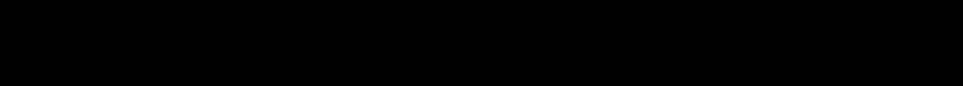

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm                            # statsmodels для OLS, WLS
from sklearn.model_selection import train_test_split    # разделение выборки

# Настройка стиля графиков
sns.set_style('whitegrid')

# Task 1

Построить простейшую линейную регрессионную модель:
1. Используя метод OLS;
2. Рассчитать коэффициенты детерминации модели на обучающей и тестовой выборках;
3. Рассчитать доверительные интервалы для функции регрессии с доверительными вероятностями 90% и 99%;
4. На диаграмме рассеяния вывести рассчитанную функцию регрессии и границы интервалов.

## Шаг 1.1: Загрузка предобработанных данных

1. Загружаем данные, сохранённые из eda.ipynb;
2. Добавляем константу для OLS (intercept);
3. Разделяем на train/test (70/30);

In [106]:
# Загружаем данные
df = pd.read_csv('../data/data_cleaned.csv')

# Выбор признаков
X = df['x']
y = df['y']

# Добавляем константу betta0 в OLS, чтобы модель не была привязана к началу координат
X_with_const = sm.add_constant(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.3, random_state=42)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (56, 2)
Размер тестовой выборки: (24, 2)


## Шаг 1.2: Построение модели OLS
### 1.2.1 Обучение модели

- Модель: $y = \beta_0 + \beta_1 \cdot x + \epsilon$;
- OLS (Метод наименьших квадратов) минимизирует: $\sum (y - \hat{y})^2$;
- Используем `statsmodels.OLS` для оценки $\beta_0, \beta_1$ и статистики;

In [107]:
# Обучение модели
model = sm.OLS(y_train, X_train)
results = model.fit()

# Вывод коэффициентов
print("Коэффициенты модели ('const', 'x'):")
print(results.params)
print("\nСводка модели:")
print(results.summary())

Коэффициенты модели ('const', 'x'):
const   -0.071021
x        3.679927
dtype: float64

Сводка модели:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     134.2
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           2.93e-16
Time:                        12:08:19   Log-Likelihood:                -96.518
No. Observations:                  56   AIC:                             197.0
Df Residuals:                      54   BIC:                             201.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

### 1.2.1 Объяснение модели

- `R-squared: 0.713`: Коэффициент детерминации $R^2$ показывает, какую долю дисперсии `y` объясняет модель. В нашем случае `71.3%` вариации `y` объясняется линейной зависимостью от `x`;
- `Adj. R-squared: 0.708`: Скорректированный $R^2$ учитывает число признаков в модели. Так как выборка небольшая, а признак всего один, то получили значение немного меньше обычного $R^2$;
- `F-statistic: 134.2`: F-статистика проверяет гипотезу: "Все коэффициенты (кроме константы) равны нулю". Большое значение (`134.2`) указывает, что модель значима, то есть `x` действительно влияет на `y`;
- `Prob (F-statistic): 2.93e-16`: p-значение для F-теста. Маленькое значение говорит, что мы отвергаем гипотезу, что `x` не влияет на `y`;
- `Log-Likelihood: -96.518`: Логарифм правдоподобия модели (предполагается нормальность ошибок $\epsilon$). Чем выше (меньше по модулю), тем лучше модель соответствует данным. У нас достаточно маленький, но это не критично для простой регрессии;
- `AIC: 197.0`: Критерий Акаике. Используется для сравнения моделей: меньше — лучше. Для одной модели не так важен;
- `BIC: 201.1`: Критерий Байеса. Похож на AIC, но штрафует за сложность сильнее. Тоже используется для сравнения моделей;

В итоге получили модель: $y = -0.0710 + 3.6799 \cdot x$.

## Шаг 1.3: Коэффициент детерминации (R²)

$ R^2 $ сравнивает, насколько модель (линейная регрессия $ \hat{y} = \beta_0 + \beta_1 \cdot x $) лучше объясняет `y`, чем просто среднее $ \bar{y} $.
Интерпретация:
- $ R^2 = 0 $: Модель не объясняет вариацию 'y' (хуже, чем просто среднее);
- $ R^2 = 1 $: Модель идеально предсказывает 'y' (все точки лежат на линии регрессии);

Формула:
<p style="text-align: center;">
$R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}$
</p>

Вычисляем:
- На train: из `results.rsquared`;
- На test: предсказываем и считаем `r2_score`;

In [108]:
# Функция для взвешенного R² (для OLS weights=1)
def calculate_r2(f_model, f_x, f_y, weights=None):
    if weights is None:
        weights = np.ones_like(f_y)  # Для OLS
    y_pred = f_model.predict(f_x)
    ss_total = np.sum(weights * (f_y - np.mean(f_y))**2)
    ss_residual = np.sum(weights * (f_y - y_pred)**2)
    r2 = 1 - ss_residual / ss_total
    return r2

In [109]:
# R² на обучающей выборке
r2_train = calculate_r2(results, X_train, y_train)
print("Коэффициент детерминации на обучающей выборке ('R²'):", round(r2_train, 3))

# R² на тестовой
r2_test = calculate_r2(results, X_test, y_test)
print("Коэффициент детерминации на тестовой выборке ('R²'):", round(r2_test, 3))

Коэффициент детерминации на обучающей выборке ('R²'): 0.713
Коэффициент детерминации на тестовой выборке ('R²'): 0.673



$ R^2 = 0.713 $: Модель объясняет 71.3% дисперсии 'y'. Остальные 28.7% — это необъяснённая дисперсия (ошибки модели или влияние других факторов).

## Шаг 1.4: Доверительные интервалы (90% и 99%)

Формула:
<p style="text-align: center;">
$\hat{y} \pm t_{\alpha/2, n-2} \cdot \text{SE}(\hat{y})$,
</p>
где $t$ — из t-распределения, $SE$ — стандартная ошибка.

- 90% интервал: $\alpha = 0.1$;
- 99% интервал: $\alpha = 0.01$;

In [110]:
# Функция для доверительных интервалов
def get_conf_intervals(f_model, f_x, f_alpha):
    f_pred = f_model.get_prediction(f_x)
    conf_int = f_pred.conf_int(alpha=f_alpha)
    return conf_int

In [111]:
# Сортируем данные по X
is_sorted = (df['x'] == df['x'].sort_values()).all()
if not is_sorted:
    df_sorted = df.sort_values('x')
    X_all = sm.add_constant(df_sorted['x'])
else:
    df_sorted = df
    X_all = sm.add_constant(df['x'])
pred = results.get_prediction(X_all)

# 90% интервал
conf_int_90 = get_conf_intervals(results, X_all, f_alpha=0.1)
print("Доверительные интервалы 90% (первые 5 строк):")
print(conf_int_90[:5])

# 99% интервал
conf_int_99 = get_conf_intervals(results, X_all, f_alpha=0.01)
print("Доверительные интервалы 99% (первые 5 строк):")
print(conf_int_99[:5])

Доверительные интервалы 90% (первые 5 строк):
[[-0.66176026  0.59331634]
 [-0.55743847  0.67438928]
 [-0.45318994  0.75553549]
 [-0.34901894  0.83675923]
 [-0.24493008  0.9180651 ]]
Доверительные интервалы 99% (первые 5 строк):
[[-1.03538882  0.96694489]
 [-0.92414599  1.0410968 ]
 [-0.81302004  1.11536558]
 [-0.70201779  1.18975807]
 [-0.59114657  1.26428159]]


## Шаг 1.5: Визуализация

Диаграмма рассеяния (график `y` от `x`) с:
- Точками данных (`x`, `y`);
- Линией регрессии ($\hat{y} = \beta_0 + \beta_1 \cdot x$);
- Заштрихованными интервалами (`90%` — синий, `99%` — зелёный);

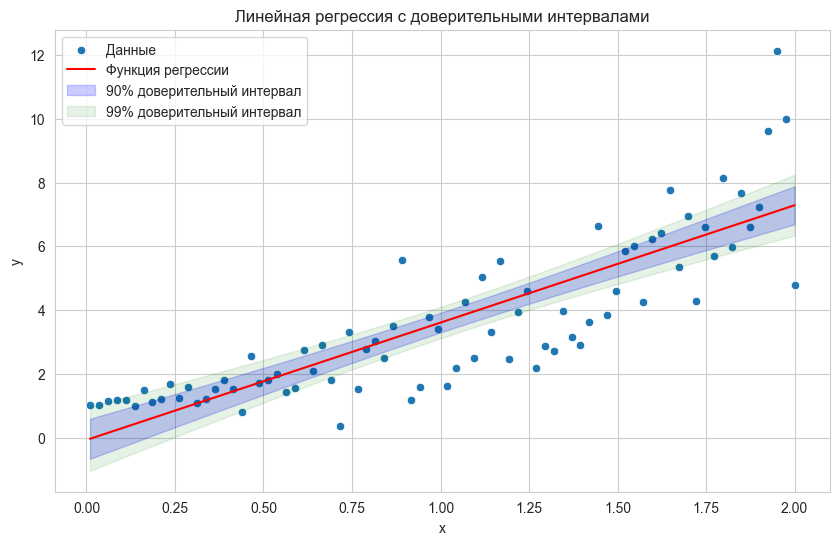

In [112]:
y_pred_all = pred.predicted_mean

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['x'], y=df['y'], label='Данные')

# Линия регрессии
plt.plot(df_sorted['x'], y_pred_all, color='red', label='Функция регрессии')

# 90% интервал
plt.fill_between(df_sorted['x'], conf_int_90[:, 0], conf_int_90[:, 1],
                 color='blue', alpha=0.2, label='90% доверительный интервал')

# 99% интервал
plt.fill_between(df_sorted['x'], conf_int_99[:, 0], conf_int_99[:, 1],
                 color='green', alpha=0.1, label='99% доверительный интервал')

plt.title("Линейная регрессия с доверительными интервалами")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Шаг 1.6: Выводы

- Объём выборки: `79` строк, `2` столбца (`x`, `y`).
- Разделение: `70%` train (`56` строк), `30%` test (`24` строки).
- Модель: Линейная регрессия $y = \beta_0 + \beta_1 \cdot x$.
- R²:
    - Train: `0.713` — доля объяснённой дисперсии на обучающей выборке;
    - Test:  `0.673` — доля объяснённой дисперсии на тестовой выборке;
- Интервалы:
    - `90%` — более узкие, подходят для умеренной уверенности;
    - `99%` — шире, для высокой уверенности;



# Task 2

1. Построить графики зависимости остатков модели:
    - от моделируемых значений;
    - от входной переменной;
2. Провести качественный анализ на гетероскедастичность остатков.

*__Примечание__: Для качественного анализа на гетероскедастичность остатков провести группировку значений входной переменной и рассчитать дисперсии остатков модели в каждой группе. Результат представить в виде графика зависимости групповой дисперсии от номера группы.*
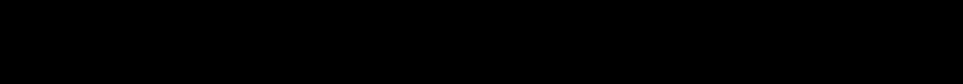
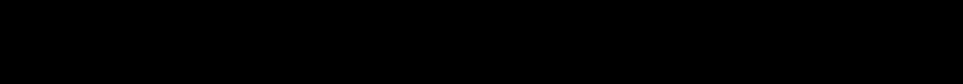
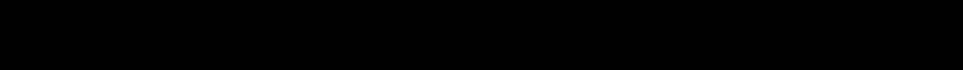
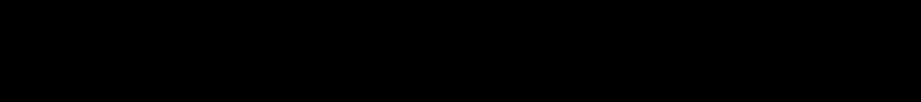
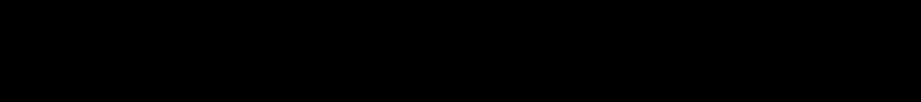
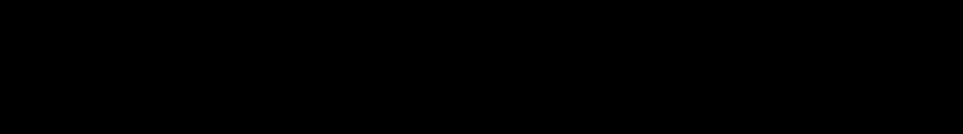
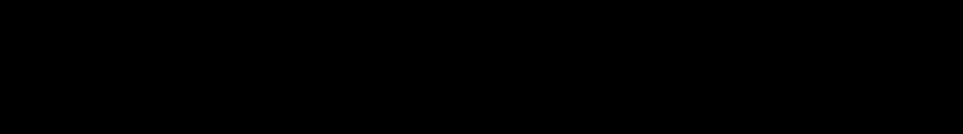

## Шаг 2.1: Визуализация остатков модели

Остатки:
<p style="text-align: center;">
$e_i = y_i - \hat{y}_i$,
</p>
где $\hat{y}_i$ — предсказания модели на обучающей выборке.

Графики помогают выявить паттерны (нелинейность, гетероскедастичность).

In [113]:
# Остатки на обучающей выборке
residuals = y_train - results.fittedvalues
print(residuals.head())

34    0.393011
62   -1.448389
42    0.405459
54   -1.808983
16    0.071564
dtype: float64


График 1: Остатки от моделируемых значений (ŷ)
График 2: Остатки от входной переменной ('x')

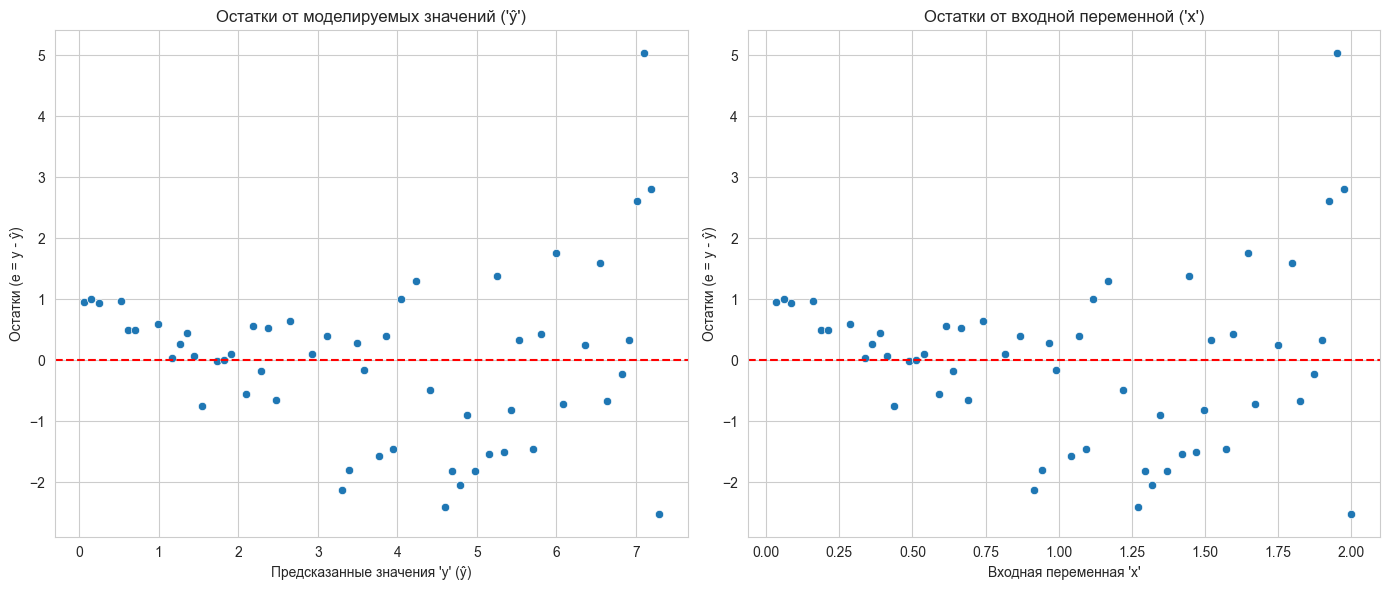

In [114]:
# Создаём полотно с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=results.fittedvalues, y=residuals, ax=ax1)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("Остатки от моделируемых значений ('ŷ')")
ax1.set_xlabel("Предсказанные значения 'y' (ŷ)")
ax1.set_ylabel("Остатки (e = y - ŷ)")

sns.scatterplot(x=X_train['x'], y=residuals, ax=ax2)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title("Остатки от входной переменной ('x')")
ax2.set_xlabel("Входная переменная 'x'")
ax2.set_ylabel("Остатки (e = y - ŷ)")

plt.tight_layout()
plt.show()

## Шаг 2.2: Качественный анализ гетероскедастичности

Гетероскедастичность: Дисперсия остатков меняется в зависимости от `x` или `ŷ`.
- Если остатки случайны и имеют постоянный разброс вокруг `0`, это гомоскедастичность;
- Если разброс остатков увеличивается/уменьшается (например, "воронка"), это гетероскедастичность;

Для анализа гетероскедастичности:
- Группируем `x` на `5` групп (по `11–12` строк на группу).
- Для каждой группы вычисляем дисперсию остатков:
<p style="text-align: center;">
$\text{Var}(e) = \frac{1}{n_j - 1} \sum_{i \in \text{группа } j} (e_i - \bar{e}_j)^2$
</p>

- Рисуем график дисперсий от номера группы. Это покажет, меняется ли дисперсия.

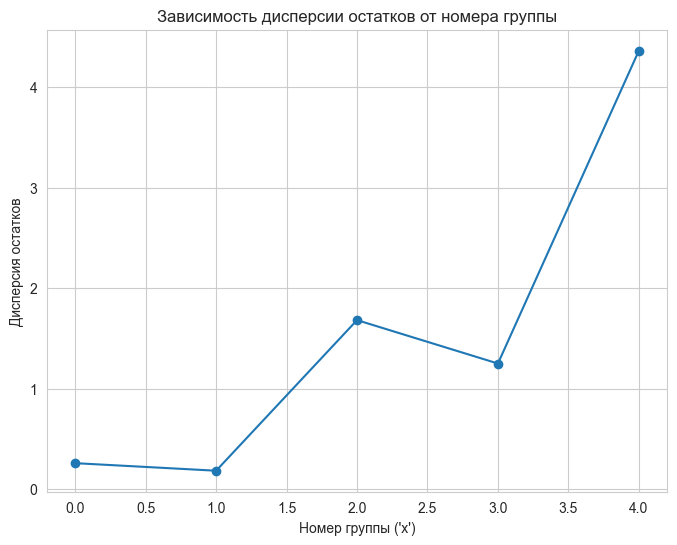

Дисперсии остатков по группам:
group
0    0.260768
1    0.185598
2    1.683228
3    1.251483
4    4.362228
Name: residuals, dtype: float64


In [115]:
# Группировка 'x' на 5 групп
n_groups = 5
df_train = pd.DataFrame({'x': X_train['x'], 'residuals': residuals})
df_train['group'] = pd.qcut(df_train['x'], q=n_groups, labels=False)

# Вычисление дисперсии остатков в каждой группе
group_variances = df_train.groupby('group')['residuals'].var()

# График зависимости дисперсии от номера группы
plt.figure(figsize=(8, 6))
plt.plot(group_variances.index, group_variances.values, marker='o')
plt.title("Зависимость дисперсии остатков от номера группы")
plt.xlabel("Номер группы ('x')")
plt.ylabel("Дисперсия остатков")
plt.grid(True)
plt.show()

# Вывод дисперсий
print("Дисперсии остатков по группам:")
print(group_variances)

### Шаг 2.3: Выводы по гетероскедастичности
Наблюдения:
Дисперсии остатков по группам:
- Группа 0: 0.260768
- Группа 1: 0.185598
- Группа 2: 1.683228
- Группа 3: 1.251483
- Группа 4: 4.362228

Дисперсия растёт с номером группы (то есть с увеличением 'x'), что указывает на гетероскедастичность.

# Task 3

1. Построить простейшую линейную регрессионную модель модулей остатков на входную переменную.
2. Проверить значимость модели:
    - привести статистическую гипотезу;
    - указать значение статистики критерия и p-значение;
    - сформулировать статистическое решение;
3. Сделать вывод о гетероскедастичности исходных данных.
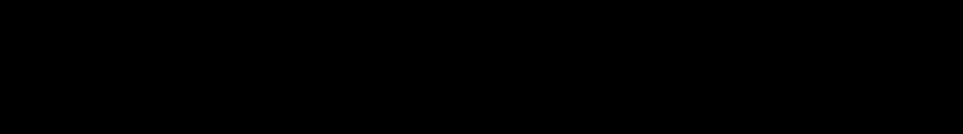

## Шаг 3.1: Построение регрессии модулей остатков

Модель:
<p style="text-align: center;">
$|e_i| = \gamma_0 + \gamma_1 \cdot x_i + \epsilon_i ), где ( |e_i| = |y_i - \hat{y}_i|$.
</p>


In [116]:
# Остатки исходной модели
residuals = y_train - results.fittedvalues
# Модули остатков
abs_residuals = np.abs(residuals)

# Построение регрессии |e| на 'x'
X_train_const = sm.add_constant(X_train['x'])  # Добавляем константу
model_abs_res = sm.OLS(abs_residuals, X_train_const).fit()

# Сводка модели
print("Сводка модели регрессии модулей остатков:")
print(model_abs_res.summary())

Сводка модели регрессии модулей остатков:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     16.83
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000139
Time:                        12:08:19   Log-Likelihood:                -66.658
No. Observations:                  56   AIC:                             137.3
Df Residuals:                      54   BIC:                             141.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

## Шаг 3.2: Проверка значимости модели

Гипотеза:
- $H_0$: $\gamma_1 = 0$ (модули остатков не зависят от 'x', __гомоскедастичность__).
- $H_1$: $\gamma_1 \neq 0$ (модули остатков зависят от 'x', __гетероскедастичность__).

Статистика критерия:
- __F-статистика__ — это критерий, который измеряет, насколько модель улучшает предсказания по сравнению с базовой (нулевой) моделью.
- __p-значение__: это вероятность получить F-статистику (или больше) при условии, что $ H_0 $ верна ($ \gamma_1 = 0 $).

Статистическое решение:
- Если $p < 1-\alpha$, отвергаем $H_0$, модель значима, есть гетероскедастичность.
- Если $p \geq 1-\alpha$, берём $H_0$, гомоскедастичность.

_Примечание: Уровень значимости $\alpha = 0.95$_

In [117]:
# Извлечение F-статистики и p-значения
f_stat = model_abs_res.fvalue
p_value = model_abs_res.f_pvalue
alpha = 0.95

print("F-статистика:", round(f_stat, 3))
print("p-значение:", round(p_value, 3))
print("Статистическое решение:",
      "Отвергаем H₀ (гетероскедастичность)" if p_value < 1 - alpha else "Не отвергаем H₀ (гомоскедастичность)")

F-статистика: 16.826
p-значение: 0.0
Статистическое решение: Отвергаем H₀ (гетероскедастичность)


## Шаг 3.3: Визуализация регрессии модулей остатков

Построим график для наглядности зависимости |e| от 'x'.

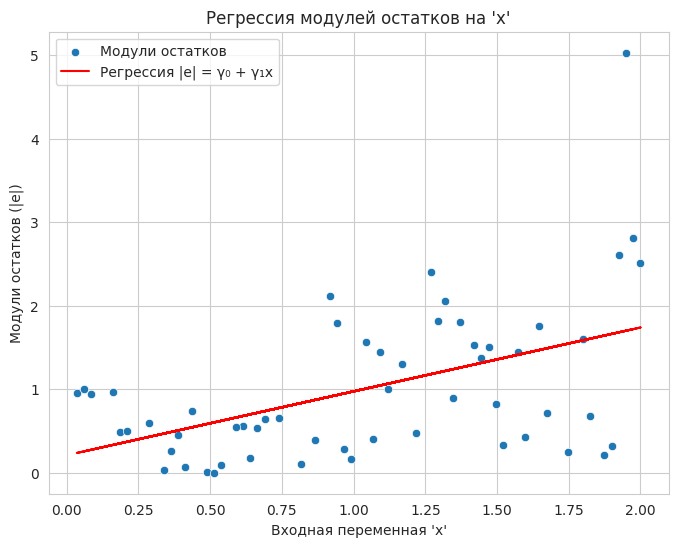

In [118]:
# Параметры отрисовки
plt.rcParams['font.family'] = 'DejaVu Sans'

# Предсказания модели |e|
y_pred_abs_res = model_abs_res.fittedvalues

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['x'], y=abs_residuals, label='Модули остатков')
plt.plot(X_train['x'], y_pred_abs_res, color='red', label='Регрессия |e| = γ₀ + γ₁x')
plt.title("Регрессия модулей остатков на 'x'")
plt.xlabel("Входная переменная 'x'")
plt.ylabel("Модули остатков (|e|)")
plt.legend()
plt.show()

## Шаг 3.4: Вывод о гетероскедастичности

Статистическая гипотеза о гетероскедастичности была __подтверждена__, что соответствует результатам значений дисперсии остатков по группам, полученных в Задании 2.
Также, по визуализации регрессии модулей остатков видно, что они растут с ростом `x`, что указывает на гетероскедастичность.

# Task 4

1. Построить простейшую линейную регрессионную модель, используя метод WLS.
В качестве весов наблюдений использовать:
    - а) величины, обратные модельным значениям функции регрессии, построенной в п. 3;
    - б) величины, равные 1/x;
2. Рассчитать:
    - коэффициенты детерминации моделей на обучающей и тестовой выборках;
    - границы доверительных интервалов для функции регрессии;
    - сравнить построенные модели с моделью, полученной в п. 1;

_Примечание: если в результате построения регрессионной модели в п.4. получаются близкие к нулю или отрицательные модельные значения функции регрессии, то в качестве весов использовать значения $ w_i = 1 / (c + x_i) $, где $ c = const $._


## Шаг 4.1: WLS a) с весами $f_i(x_i)$
__WLS (Weighted Least Squares)__ — взвешенный метод наименьших квадратов, который минимизирует взвешенную сумму квадратов остатков:
<p style="text-align: center;">
$\sum w_i (y_i - \hat{y}_i)^2$
</p>

$w_i$ — веса, присваиваемые каждому наблюдению.
### 4.1.1 Построение модели

In [119]:
# Предсказания из модели п. 3 (model_abs_res)
f_i_train = model_abs_res.fittedvalues      # f_i(x_i) для train
f_i_test = model_abs_res.predict(X_test)    # f_i(x_i) для test

c = 0.001                                   # Константа, предотвращающая ошибку деления на 0
weights_a_train = 1 / (c + f_i_train)
weights_a_test = 1 / (c + f_i_test)

# WLS модель а
model_wls_a = sm.WLS(y_train, X_train, weights=weights_a_train).fit()

print("Сводка WLS а:")
print(model_wls_a.summary())

Сводка WLS а:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            WLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           7.42e-18
Time:                        12:08:19   Log-Likelihood:                -86.838
No. Observations:                  56   AIC:                             177.7
Df Residuals:                      54   BIC:                             181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4138      0.230      

### 4.1.2 Коэффициенты детерминации

In [120]:
# R² на train
r2_train_a = calculate_r2(model_wls_a, X_train, y_train, weights_a_train)

# R² на test
r2_test_a = calculate_r2(model_wls_a, X_test, y_test, weights_a_test)

print("R² на train (а):", round(r2_train_a, 3))
print("R² на test (а):", round(r2_test_a, 3))

R² на train (а): 0.799
R² на test (а): 0.75


### 4.1.3 Доверительные интервалы

In [121]:
# Интервалы для всей выборки (90%, 99%)
X_all = sm.add_constant(df['x'])

conf_int_90_a = get_conf_intervals(model_wls_a, X_all, f_alpha=0.1)
conf_int_99_a = get_conf_intervals(model_wls_a, X_all, f_alpha=0.01)

print("90% интервалы (а, первые 5):", conf_int_90_a[:5])
print("99% интервалы (а, первые 5):", conf_int_99_a[:5])

90% интервалы (а, первые 5): [[0.06383789 0.82811259]
 [0.15299966 0.90079819]
 [0.24203628 0.97360895]
 [0.33093923 1.04655338]
 [0.41969936 1.11964063]]
99% интервалы (а, первые 5): [[-0.16368197  1.05563245]
 [-0.06961534  1.1234132 ]
 [ 0.02425161  1.19139362]
 [ 0.11790531  1.2595873 ]
 [ 0.21133117  1.32800882]]


## Шаг 4.2: WLS б) с весами $1 / x$
### 4.2.1 Построение модели

К весам $1 / x$, добавляем `c = 0.001` для избежания деления на `0`.

In [122]:
weights_b_train = 1 / (c + X_train['x'])
weights_b_test = 1 / (c + X_test['x'])

# WLS модель б
model_wls_b = sm.WLS(y_train, X_train, weights=weights_b_train).fit()

print("Сводка WLS б:")
print(model_wls_b.summary())

Сводка WLS б:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            WLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     191.0
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           2.26e-19
Time:                        12:08:19   Log-Likelihood:                -83.500
No. Observations:                  56   AIC:                             171.0
Df Residuals:                      54   BIC:                             175.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7215      0.141      

### 4.2.2 Коэффициенты детерминации

In [123]:
# R² на train
r2_train_b = calculate_r2(model_wls_b, X_train, y_train, weights_b_train)

# R² на test
r2_test_b = calculate_r2(model_wls_b, X_test, y_test, weights_b_test)

print("R² на train (б):", round(r2_train_b, 3))
print("R² на test (б):", round(r2_test_b, 3))

R² на train (б): 0.895
R² на test (б): 0.929


### 4.2.3 Доверительные интервалы

In [124]:
# Интервалы для всей выборки (90%, 99%)
conf_int_90_b = get_conf_intervals(model_wls_b, X_all, f_alpha=0.1)
conf_int_99_b = get_conf_intervals(model_wls_b, X_all, f_alpha=0.01)
print("90% интервалы (б, первые 5):", conf_int_90_b[:5])
print("99% интервалы (б, первые 5):", conf_int_99_b[:5])

90% интервалы (б, первые 5): [[0.51652007 0.98482186]
 [0.59552388 1.05272411]
 [0.67431113 1.12084291]
 [0.75286596 1.18919414]
 [0.83117169 1.25779448]]
99% интервалы (б, первые 5): [[0.37710952 1.12423241]
 [0.45941819 1.1888298 ]
 [0.54138138 1.25377267]
 [0.62297376 1.31908635]
 [0.70416871 1.38479745]]


## Шаг 4.3: Сравнение моделей

Сравниваем WLS а), WLS б) с OLS из п. 1

### 4.3.1 Сравниваем коэффициенты детерминации

In [125]:
# R² сравнение
print("Сравнение R²:")
print("OLS: train =", round(results.rsquared, 3), "test =", round(r2_test, 3))
print("WLS а: train =", round(r2_train_a, 3), "test =", round(r2_test_a, 3))
print("WLS б: train =", round(r2_train_b, 3), "test =", round(r2_test_b, 3))

Сравнение R²:
OLS: train = 0.713 test = 0.673
WLS а: train = 0.799 test = 0.75
WLS б: train = 0.895 test = 0.929


### 4.3.2 Сравнение по графикам

In [126]:
# Функция для графиков
def plot_conf_intervals(f_model, f_x, f_y, f_conf_int_90, f_conf_int_99, title, ax):
    y_pred = f_model.get_prediction(sm.add_constant(f_x)).predicted_mean
    ax.scatter(f_x, f_y, color='black', s=10, label='Данные')
    ax.fill_between(f_x, f_conf_int_90[:, 0], f_conf_int_90[:, 1], color='blue', alpha=0.2, label='90% ДИ')
    ax.plot(f_x, f_conf_int_99[:, 0], color='blue', linestyle='--', label='99% ДИ')
    ax.plot(f_x, f_conf_int_99[:, 1], color='blue', linestyle='--')
    ax.plot(f_x, y_pred, color='red', label='Регрессия')
    ax.set_title(title)
    ax.set_xlabel("Входная переменная 'x'")
    ax.set_ylabel("Целевая переменная 'y'")
    ax.legend()

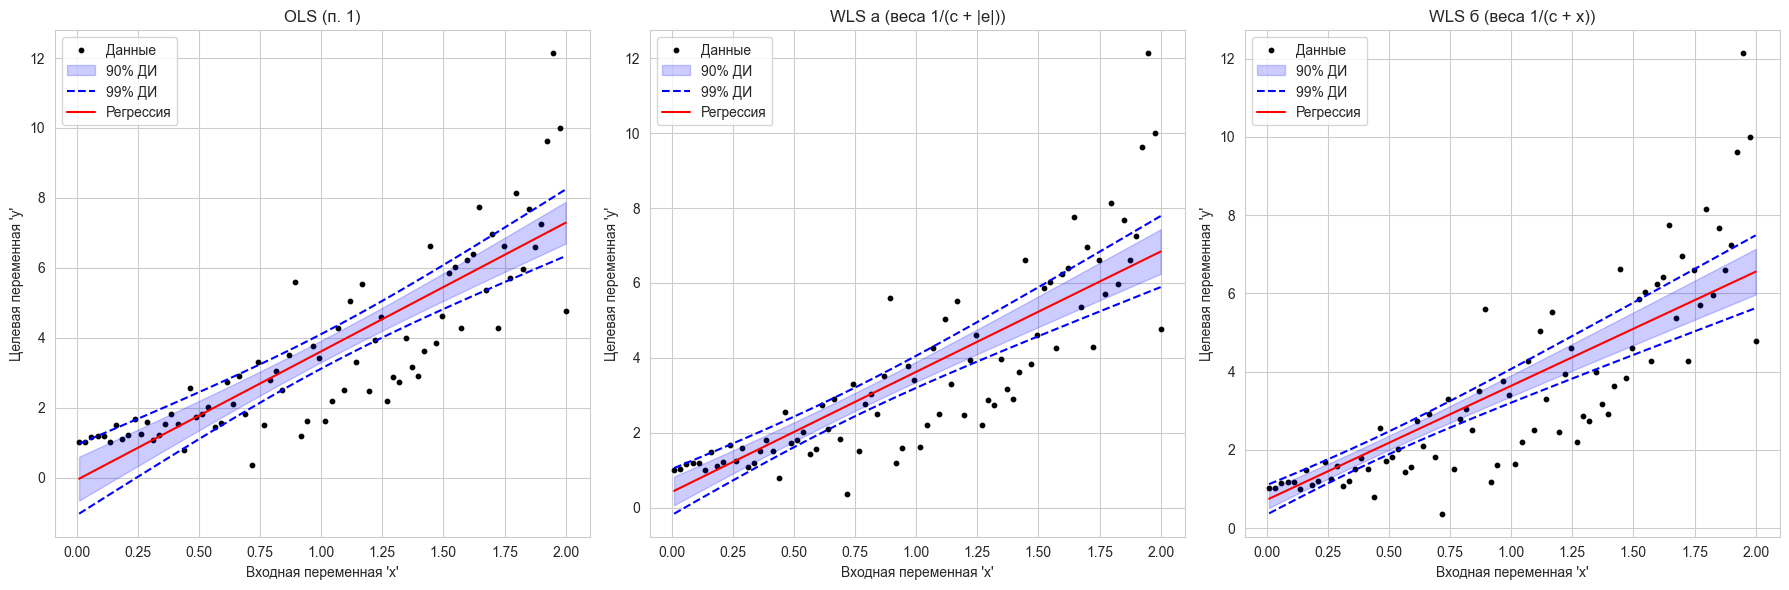

In [133]:
# Графики
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot_conf_intervals(results, df['x'], df['y'], conf_int_90, conf_int_99, "OLS (п. 1)", ax1)
plot_conf_intervals(model_wls_a, df['x'], df['y'], conf_int_90_a, conf_int_99_a, "WLS а (веса 1/(c + |e|))", ax2)
plot_conf_intervals(model_wls_b, df['x'], df['y'], conf_int_90_b, conf_int_99_b, "WLS б (веса 1/(c + x))", ax3)

plt.tight_layout()
plt.show()

## Шаг 4.4 Вывод

Наблюдения R²:
- __OLS__ (train=0.713, test=0.673);
- __WLS а)__ (train=0.799, test=0.750);
- __WLS б)__ (train=0.895, test=0.929);

__WLS б)__ — лучшая модель: высокий R²_test, эффективная коррекция гетероскедастичности.
__WLS а)__: хорошая, но менее точная.

# Task 5

1. Построить гистограммы распределения остатков моделей, полученных в пп. 1 и 4;
2. На обучающей и тестовой выборках, проверить распределения остатков на нормальность, используя критерий «хи-квадрат»:
    - привести значения статистики критерия
    - p-value
    - статистическое решение

_Примечание: После обучения регрессионной модели методом WLS остатки модели скорректировать с учетом весов $ e'(x) = e(x) \cdot w(x) $._
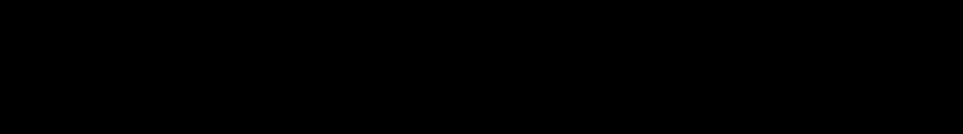
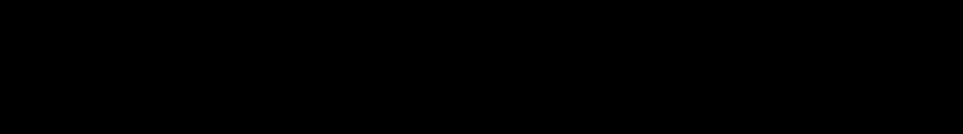
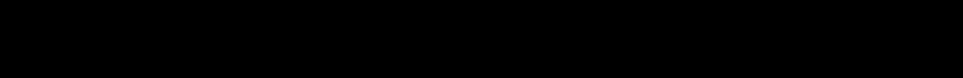
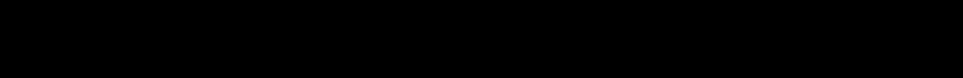

## Шаг 5.1: Гистограммы распределения остатков моделей



In [128]:
# Остатки OLS
residuals_ols_train = y_train - results.fittedvalues
residuals_ols_test = y_test - results.predict(X_test)

# Остатки WLS а
residuals_a_train = y_train - model_wls_a.fittedvalues
residuals_a_test = y_test - model_wls_a.predict(X_test)
weights_a_train = 1 / (0.001 + model_abs_res.fittedvalues)
weights_a_test = 1 / (0.001 + model_abs_res.predict(X_test))
residuals_a_train_weighted = residuals_a_train * weights_a_train
residuals_a_test_weighted = residuals_a_test * weights_a_test

# Остатки WLS б
residuals_b_train = y_train - model_wls_b.fittedvalues
residuals_b_test = y_test - model_wls_b.predict(X_test)
weights_b_train = 1 / (0.001 + X_train['x'])
weights_b_test = 1 / (0.001 + X_test['x'])
residuals_b_train_weighted = residuals_b_train * weights_b_train
residuals_b_test_weighted = residuals_b_test * weights_b_test

In [129]:
def paint_hist(f_residuals, bins, f_axes, label):
    sns.histplot(f_residuals, bins=bins, kde=True, ax=f_axes)
    f_axes.set_title(label)
    f_axes.set_xlabel("Остатки")
    f_axes.set_ylabel("Частота")

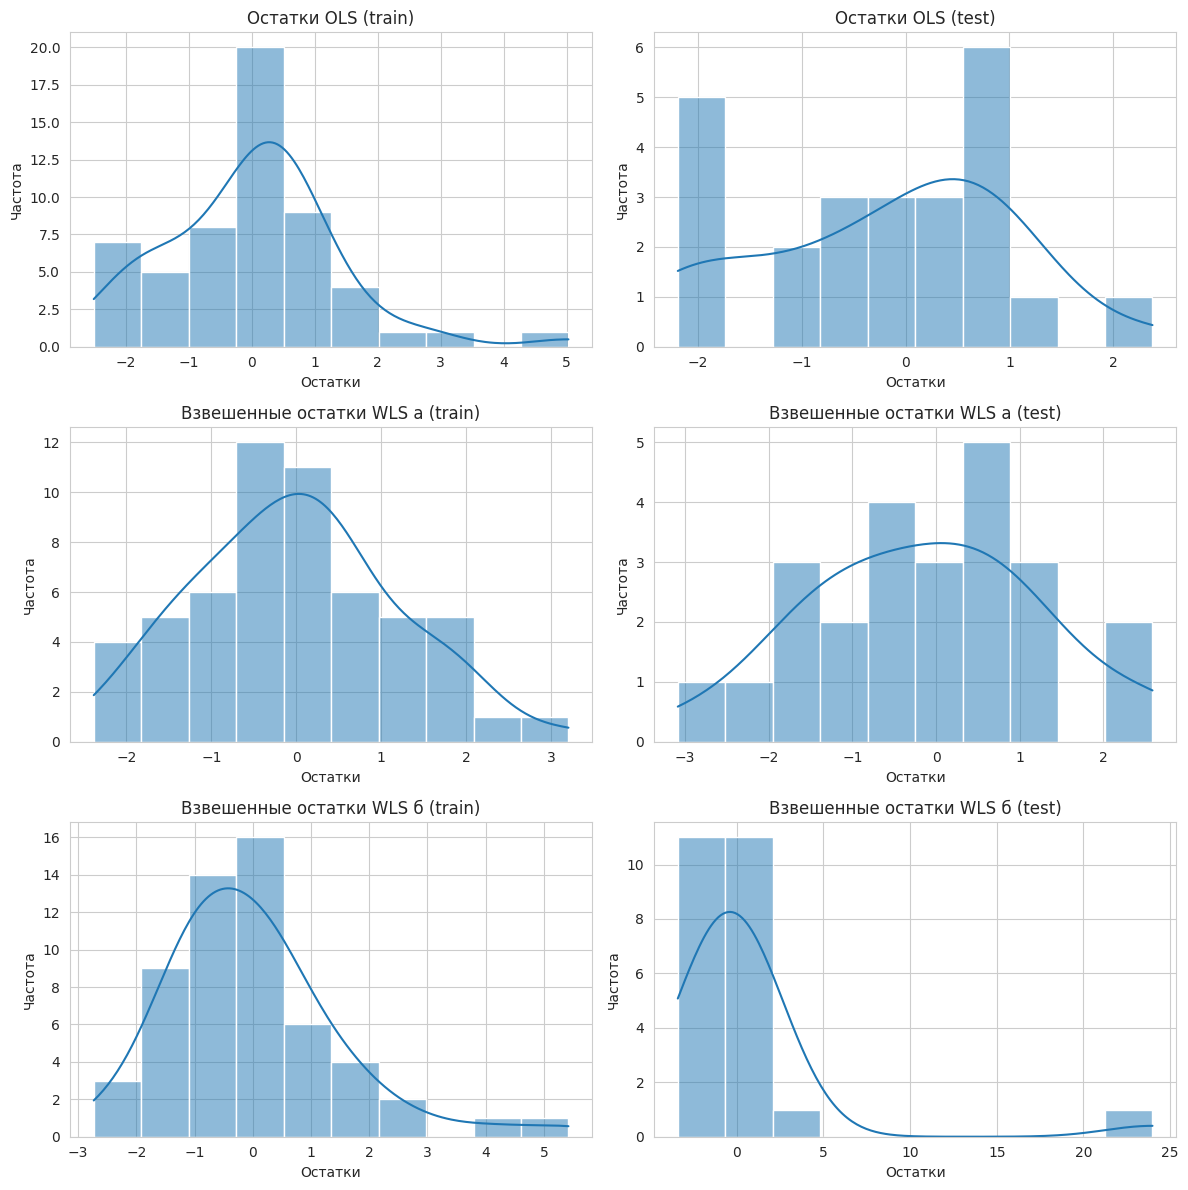

In [130]:
# Гистограммы
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# OLS train
paint_hist(residuals_ols_train, bins=10, f_axes=axes[0, 0], label="Остатки OLS (train)")

# OLS test
paint_hist(residuals_ols_test, bins=10, f_axes=axes[0, 1], label="Остатки OLS (test)")

# WLS а train (взвешенные)
paint_hist(residuals_a_train_weighted, bins=10, f_axes=axes[1, 0], label="Взвешенные остатки WLS а (train)")

# WLS а test (взвешенные)
paint_hist(residuals_a_test_weighted, bins=10, f_axes=axes[1, 1], label="Взвешенные остатки WLS а (test)")

# WLS б train (взвешенные)
paint_hist(residuals_b_train_weighted, bins=10, f_axes=axes[2, 0], label="Взвешенные остатки WLS б (train)")

# WLS б test (взвешенные)
paint_hist(residuals_b_test_weighted, bins=10, f_axes=axes[2, 1], label="Взвешенные остатки WLS б (test)")

plt.tight_layout()
plt.show()

## Шаг 5.2: Проверка нормальности (хи-квадрат)

Критерий хи-квадрат проверяет, соответствует ли распределение остатков нормальному.
Гипотезы:
- $ H_0 $: Остатки распределены нормально.
- $ H_1 $: Остатки не нормальны.

Статистика:
<p style="text-align: center;">
$ \chi^2 = \sum \frac{(O_i - E_i)^2}{E_i} $,
</p>

где
- $ O_i $ — наблюдаемые частоты в бинах гистограммы,
- $ E_i $ — ожидаемые частоты для нормального распределения.

_p-value_ $< 1-\alpha$: Отвергаем $ H_0 $ - остатки не нормальны.

In [131]:
from scipy.stats import norm, chi2


def chi_square_normality_test(f_residuals, bins=10):
    # Число наблюдений
    n = len(f_residuals)

    # Гистограмма остатков (наблюдаемые частоты)
    hist, bin_edges = np.histogram(f_residuals, bins=bins)

    # Ожидаемые частоты для нормального распределения
    mu = np.mean(f_residuals)
    sigma = np.std(f_residuals)
    expected = np.zeros(len(hist))
    for i in range(len(bin_edges) - 1):
        # Вероятность в бине: CDF(b) - CDF(a)
        prob = norm.cdf(bin_edges[i + 1], mu, sigma) - norm.cdf(bin_edges[i], mu, sigma)
        expected[i] = n * prob

    # Убедимся, что ожидаемые частоты ненулевые
    expected = np.where(expected < 5, 5, expected)  # Минимальная частота 5

    # Хи-квадрат статистика
    chi2_stat = np.sum((hist - expected)**2 / expected)

    # Степени свободы: число бинов - 1 - 2 (для mu, sigma)
    f_df = len(hist) - 1 - 2

    # p-значение
    f_p_value = 1 - chi2.cdf(chi2_stat, f_df) if f_df > 0 else np.nan

    return chi2_stat, f_p_value

In [132]:
# Хи-квадрат тесты
chi2_ols_train, p_ols_train = chi_square_normality_test(residuals_ols_train, bins=10)
chi2_ols_test, p_ols_test = chi_square_normality_test(residuals_ols_test, bins=5)
chi2_a_train, p_a_train = chi_square_normality_test(residuals_a_train_weighted, bins=10)
chi2_a_test, p_a_test = chi_square_normality_test(residuals_a_test_weighted, bins=5)
chi2_b_train, p_b_train = chi_square_normality_test(residuals_b_train_weighted, bins=10)
chi2_b_test, p_b_test = chi_square_normality_test(residuals_b_test_weighted, bins=5)

# Вывод результатов
print("Критерий хи-квадрат для нормальности:")
print("OLS (train): χ² =", round(chi2_ols_train, 3), "p-value =", round(p_ols_train, 5),
      "Решение:", "Не нормальны" if p_ols_train < 1 - alpha else "Нормальны")
print("OLS (test): χ² =", round(chi2_ols_test, 3), "p-value =", round(p_ols_test, 5),
      "Решение:", "Не нормальны" if p_ols_test < 1 - alpha else "Нормальны")
print("WLS а (train): χ² =", round(chi2_a_train, 3), "p-value =", round(p_a_train, 5),
      "Решение:", "Не нормальны" if p_a_train < 1 - alpha else "Нормальны")
print("WLS а (test): χ² =", round(chi2_a_test, 3), "p-value =", round(p_a_test, 5),
      "Решение:", "Не нормальны" if p_a_test < 1 - alpha else "Нормальны")
print("WLS б (train): χ² =", round(chi2_b_train, 3), "p-value =", round(p_b_train, 5),
      "Решение:", "Не нормальны" if p_b_train < 0.05 else "Нормальны")
print("WLS б (test): χ² =", round(chi2_b_test, 3), "p-value =", round(p_b_test, 5),
      "Решение:", "Не нормальны" if p_b_test < 0.05 else "Нормальны")

Критерий хи-квадрат для нормальности:
OLS (train): χ² = 22.759 p-value = 0.00188 Решение: Не нормальны
OLS (test): χ² = 4.347 p-value = 0.11378 Решение: Нормальны
WLS а (train): χ² = 8.496 p-value = 0.29093 Решение: Нормальны
WLS а (test): χ² = 4.354 p-value = 0.11338 Решение: Нормальны
WLS б (train): χ² = 18.824 p-value = 0.00876 Решение: Не нормальны
WLS б (test): χ² = 34.505 p-value = 0.0 Решение: Не нормальны


# Общие выводы

В ходе проведения лабораторной работы, проводился анализ данных из файла `data_v1-06.csv` (исходно `80` строк, две переменные: `x` — признак, `y` — целевая), включая:
 - пред обработку данных;
 - построение моделей линейной регрессии (OLS и WLS);
 - анализ остатков;
 - проверку нормальности и гетероскедастичности;

**Задание 0. Этап предобработки данных (EDA)**
1. На данном этапе был выявлен и удалён выброс (`y = 12.134`), так выборка сократилась до `79` строк.
2. Была рассчитана корреляция между `x` и `y`, которая оказалась довольно сильной (`0.8421`).
3. Также были рассмотрены другие параметры нашей выборки.

**Задание 1: Простая линейная регрессия OLS**
1. Для начала было произведено разделение выборки на обучающую (70%, 56 строк) и тестовую (30%, 23 строки) выборки выполнено с random_state=42 для воспроизводимости.
2. Была построена модель $ y = \beta_0 + \beta_1 \cdot x $, где $\beta_0 = -0.0710$, $\beta_1 = 3.6799$.
3. Рассчитаны коэффициенты детерминации (R²). На обучающей выборке — `0.713` (модель объясняет `71.3%` дисперсии `y`), на тестовой — `0.673`.
4. Также были построены доверительные интервалы для `90%` и `99%` вероятностей и диаграмма рассеяния для визуализации наших данных с полученными доверительными интервалами.

**Задание 2: Графики остатков и анализ гетероскедастичности**
1. Для модели полученной в **Задании 1**, были рассчитаны остатки и построены графики этих остатков от предсказанных значений ($ \hat{y} $) и от `x`.
2. Был проведён групповой анализ: значения `x` разделены на `5` групп, в каждой из которых рассчитывались дисперсии остатков: `0.260768`, `0.185598`, `1.683228`, `1.251483`, `4.362228`. По этим данным стало понятно, что дисперсия растёт с ростом `x`, что указывает на **гетероскедастичность**.

**Задание 3: Регрессия модулей остатков**
1. По значению остатков, из **Задания 2**, была построена модель OSL: $ |e_i| = \gamma_0 + \gamma_1 \cdot x_i $, где $ |e_i| = |y_i - \hat{y}_i| $ (остатки).
2. Используя F-статистику, была проверена гипотеза о НЕ значимости модели на гомоскедастичность($\alpha = 0.95$). Так мы получили значения F-статистика `16.826`, p-значение `0.0`. Значит отвергаем $ H_0 $ (p<0.05), и гетероскедастичность подтверждена.

**Задание 4: Линейная регрессия WLS**
1. Следующим этапом была попытка избавиться от гетероскедастичности, построением модели WLS с весами:
    - а) $ w_i = 1 / (0.001 + f_i(x_i)) $, где $ f_i(x_i) $ — предсказания модели $ |e_i| $ из **Задания 3**;
    - б) Веса $ w_i = 1 / (0.001 + x_i) $;
2. Для каждой из WLS моделей а) и б) были получены значения коэффициента детерминации (R²)
    - а) `R²_train = 0.799`, `R²_test = 0.750`;
    - б) `R²_train = 0.895`, `R²_test = 0.929`;
3. Также рассчитаны `90%` и `99%` доверительные интервалы и построены диаграммы рассеяния. Так мы выяснили, что в сравнении с OLS, WLS улучшают R² (особенно на test) и сужают ДИ, корректируя гетероскедастичность. WLS б) оказалась предпочтительнее за счёт высоких значений R².

**Задание 5: Гистограммы и проверка нормальности остатков**
1. В данном задании мы сравнивали остатки модели OLS и моделей WLS при помощи построения гистограмм остатков. Стоит упомянуть, что остатки моделей WLS также были скорректированы путём взвешивания.
2. Была проверена гипотеза о "нормальности" остатков моделей, с помощью $ \chi^2 $-теста. Так были получены следующие результаты:
    - OLS (train): p=0.00188, не нормальны.
    - OLS (test): p=0.11378, нормальны.
    - WLS а (train): p=0.29093, нормальны.
    - WLS а (test): p=0.11338, нормальны.
    - WLS б (train): p=0.00876, не нормальны.
    - WLS б (test): p=0.0, не нормальны.

- Остатки OLS ненормальны на train из-за неравномерного распределения `y` (скорее всего логнормального) и гетероскедастичности.
- WLS а) корректирует остатки, делая их нормальными.
- WLS б) имеет высокие R², но ненормальные остатки из-за выброса (~25 в test), который усиливает асимметрию.

**Задание 6: Сравнение методов OLS и WLS**
1. OLS: Простой, но не учитывает гетероскедастичность, что приводит к менее эффективным оценкам, широким ДИ и ненормальным остаткам. `R²_test = 0.673` — худший результат.
2. WLS: Учитывает веса для коррекции гетероскедастичности, минимизируя $ \sum w_i (y_i - \hat{y_i})^2 $. Улучшает R², сужает ДИ и нормализует остатки.
    - WLS а): Хорошая коррекция (`R²_test = 0.750`, нормальные остатки).
    - WLS б): Лучшая по R² (`R²_test = 0.929`), но ненормальные остатки из-за выброса.



**Вывод**
Таким образом, работа подтвердила, что WLS лучше OLS в условиях гетероскедастичности, улучшая точность и обобщающую способность.
- WLS б) предпочтительнее по R², но требует обработки выброса для нормальности.
- WLS а) — баланс между точностью и нормальностью остатков.